# ACTIVIDAD 3 (GRUPAL): REDES NEURONALES RECURRENTES (RNN)

---

En esta actividad grupal, vamos a utilizar las RNN para identificar la intensidad de odio en mensajes escritos en las redes sociales. Esta actividad forma parte del proyecto transversal del Máster, ¡así que seguro que ya estás familiarizado/a con el dataset!

Por sencillez, se adjunta un documento csv que es una versión resumida del dataset original del proyecto transversal. En este dataset, solo se incluyen los mensajes que han sido catalogados como contenedores de odio. También se han eliminado las features innecesarias para este trabajo simplemente para hacer todo el proceso más rápido computacionalmente hablando.

El dataset a utilizar consiste en 12280 mensajes de odio. Los mensajes pueden pertenecer a cinco categorias (numeradadas del 1 al 5), siendo 1 la menor intensidadd y 5 la mayor intensidad de odio del mensaje. El dataset ya ha sido procesado para eliminar ciertos caracteres que podrían darte problemas y para utilizar una codificación más amigable.

INTEGRANTES DEL GRUPO:
* ANDRÉS DAVID FORERO MARTÍNEZ
* HUGO ERNESTO IGUARÁN HERNÁNDEZ
* LUIS ALBERTO VALENCIA AVELLANEDA
* LOURDES VILLAFAÑA CAMBRON




Empezamos, como siempre, incluyendo todo lo que vamos a necesitar. Según lo que vayas a hacer, es posible que necesites incluir alguna librería extra.

In [1]:
#!pip install tensorflow
#!pip install keras


In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
#from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


2025-06-14 10:57:09.043806: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/luisvalencia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/luisvalencia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


ModuleNotFoundError: No module named 'tensorflow.keras'

Cargamos el dataset. Lo encontrarás adjunto a este Notebook, al descargar la actividad del Campus Virtual.

In [ ]:
# Leemos el fichero
data = pd.read_csv('dataset.csv', sep=";", encoding='utf-8')
# Mostramos las 5 primeras filas
data.head()


,CONTENIDO A ANALIZAR,INTENSIDAD
0,cristina cifuentes podrí­a haber sido la presi...,3
1,habrí­a que reabrir el caso. el supremo se ded...,3
2,me parece un poco exagerado pedir más de tres ...,3
3,parece que todos los delincuentes niegan las e...,3
4,"preguntárselo al fracasado, media carrera en 6...",4


Cambiamos el nombre de las features para hacer su manejo más amigable:

In [ ]:
data = data.rename(columns={'CONTENIDO A ANALIZAR': 'mensaje', 'INTENSIDAD': 'intensidad'})
data.head()


,mensaje,intensidad
0,cristina cifuentes podrí­a haber sido la presi...,3
1,habrí­a que reabrir el caso. el supremo se ded...,3
2,me parece un poco exagerado pedir más de tres ...,3
3,parece que todos los delincuentes niegan las e...,3
4,"preguntárselo al fracasado, media carrera en 6...",4


Mostramos información básica para saber a qué nos enfrentamos:

In [ ]:
data.shape

(12279, 2)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12279 entries, 0 to 12278
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   mensaje     12279 non-null  object
 1   intensidad  12279 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 192.0+ KB


Mostramos ahora la distribución de mensajes de acuerdo a su intensidad. Verás rápidamente que estamos en problemas: hay un gran desbalanceo.

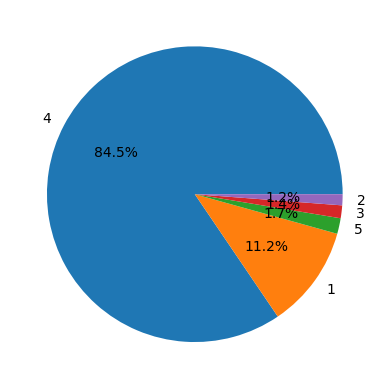

In [ ]:
plt.pie(data['intensidad'].value_counts().values,
        labels = data['intensidad'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

Para hacer todo más sencillo y evitar asociaciones indeseadas, vamos a trabajar solo con minúsculas. Además, quitamos los signos de puntuación de los mensajes

In [ ]:
# Convertimos a minúsculas
data['mensaje'] = data['mensaje'].map(lambda x: x.lower())

# Función para eliminar signos de puntuación
def eliminar_signos(texto):
    return re.sub(f"[{re.escape(string.punctuation)}]", "", texto)

# Aplicamos la función al dataset
data['mensaje'] = data['mensaje'].map(eliminar_signos)
data.head()


,mensaje,intensidad
0,cristina cifuentes podrí­a haber sido la presi...,3
1,habrí­a que reabrir el caso el supremo se dedi...,3
2,me parece un poco exagerado pedir más de tres ...,3
3,parece que todos los delincuentes niegan las e...,3
4,preguntárselo al fracasado media carrera en 6 ...,4


Eliminamos las "stopwords" o palabras vacías. Las stopwords son palabras comunes que, en general, no contienen información relevante para el análisis de texto y suelen ser filtradas antes de procesar los datos. Ejemplos típicos de stopwords en español son: "el", "la", "los", "las", "un", "una", "de", "y", "o", etc.

In [ ]:
# Obtenemos las stopwords en español
stop_words = set(stopwords.words('spanish'))
lemmatizer = WordNetLemmatizer()

# Definimos una función para eliminar stopwords y lematizar
def filtrar_palabras(texto):
    palabras_filtradas = []
    for palabra in texto.split():
        if palabra not in stop_words:
            palabra_lema = lemmatizer.lemmatize(palabra)
            palabras_filtradas.append(palabra_lema)
    return ' '.join(palabras_filtradas)

# Aplicamos la función
data['mensaje'] = data['mensaje'].apply(filtrar_palabras)
data.head()


,mensaje,intensidad
0,cristina cifuentes podrí­a haber sido presiden...,3
1,habrí­a reabrir caso supremo dedica proteger s...,3
2,parece exagerado pedir tres años prisión cifue...,3
3,parece delincuentes niegan evidencias pruebas ...,3
4,preguntárselo fracasado medium carrera 6 meses...,4


Creamos los conjuntos de entrenamiento y de test:

In [ ]:
X = data['mensaje']
y = data['intensidad']

# Dividimos el dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertimos a numpy arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Creamos datasets de TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))


Mostramos un mensaje y su intensidad, simplemente para ver que todo va bien:

In [ ]:
for men, inte in train_dataset.take(1):
  print('mensaje: ', men.numpy())
  print('nivel de odio: ', inte.numpy())


mensaje:  b'tarado abascal dice gran lider tarado trump'
nivel de odio:  4


Mezclamos los datos de forma aleatoria:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64


In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
for men, inte in train_dataset.take(1):
  print('mensaje: ', men.numpy()[:3])
  print()
  print('nivel de odio: ', inte.numpy()[:3])


mensaje:  [b'valdr\xc3\xa1 perd\xc3\xb3n pid\xc3\xa1is periodismo sociedad panfleto'
 b't\xc3\xad\xc2\xado tonto' b'lavanguardia madrit en roba paletos']

nivel de odio:  [4 4 4]


Definimos y configuramos un codificador de texto utilizando la capa TextVectorization

In [ ]:
# Empezamos definiendo el tamaño del vocabulario
tamaño_vocabulario = 1000

# Creamos una capa de vectorización de texto
vectorizador = tf.keras.layers.TextVectorization(
    max_tokens=tamaño_vocabulario
)

# Se extraen solo los textos del conjunto de datos de entrenamiento
def extraer_texto(texto, etiqueta):
    return texto

# Adaptamos el vectorizador al texto del conjunto de datos de entrenamiento
dataset_texto = train_dataset.map(extraer_texto)
vectorizador.adapt(dataset_texto)


In [ ]:
# Obtenemos el vocabulario aprendido por la capa de vectorización
vocabulario = np.array(vectorizador.get_vocabulary())

# Mostramos las primeras 20 palabras del vocabulario
primeras_20_palabras = vocabulario[:20]
primeras_20_palabras


array(['', '[UNK]', 'si', 'mierda', 'puta', 'ser', 'asco', 'gobierno',
       'panfleto', 'q', 'españa', 'paí\xads', 'gente', 'vergüenza',
       'gentuza', 'vaya', 'basura', 'va', 'gilipollas', 'solo'],
      dtype='<U25')

# Ejercicio

Construye una RNN que pueda detectar el nivel de odio de un mensaje.

**Tenéis plena liberta para realizar la red y para hacer cualquier modificación a los datos.**

In [ ]:
#Importamos las librerias

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Dropout, GlobalAveragePooling1D, Input
from tensorflow.keras.optimizers import Adam
import pandas as pd
from sklearn.model_selection import train_test_split


In [ ]:
data.head()

,mensaje,intensidad
0,cristina cifuentes podrí­a haber sido presiden...,3
1,habrí­a reabrir caso supremo dedica proteger s...,3
2,parece exagerado pedir tres años prisión cifue...,3
3,parece delincuentes niegan evidencias pruebas ...,3
4,preguntárselo fracasado medium carrera 6 meses...,4


In [ ]:
porcentaje_intensidades = data["intensidad"].value_counts(normalize=True) * 100
porcentaje_intensidades = porcentaje_intensidades.round(2)

print("Porcentaje de cada intensidad en el dataset:")
print(porcentaje_intensidades)


Porcentaje de cada intensidad en el dataset:
intensidad
4    84.49
1    11.20
5     1.71
3     1.40
2     1.21
Name: proportion, dtype: float64


Podemos observar que el dataset está desbalanceado, lo que afectará nuestro modelo.

In [ ]:
# Parámetros del modelo
tamaño_vocabulario = 5000     
dim_embedding = 128  
tamaño_lstm = 128  
learning_rate = 0.0001  


# Extraemos los mensajes
textos = data["mensaje"].astype(str).tolist()  

# Capa de vectorización con salida de longitud fija=10 (así lo acordamos como grupo pero puede modificarse)
vectorizador = TextVectorization(
    max_tokens=tamaño_vocabulario, 
    output_mode="int", 
    output_sequence_length=10
)
vectorizador.adapt(textos)

# Definimos la entrada
entrada_texto = Input(shape=(1,), dtype=tf.string)

# Construimos el modelo
x = vectorizador(entrada_texto)                                    
x = Embedding(input_dim=tamaño_vocabulario, output_dim=dim_embedding)(x)  
x = LSTM(tamaño_lstm, return_sequences=True)(x)                     
x = GlobalAveragePooling1D()(x)                                   
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
salida = Dense(1, activation="linear")(x)                           

modelo = Model(inputs=entrada_texto, outputs=salida)
modelo.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse", metrics=["mae"])

# Mostramos la estructura del modelo
modelo.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_4            │ (None, 10)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 10, 128)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 779,905 (2.98 MB)

 Trainable params: 779,905 (2.98 MB)

 Non-trainable params: 0 (0.00 B)

El primer paso para la construcción de nuestra RNN consiste en lo siguiente:

* Establecimos el tamaño del vocabulario en 5000, lo que significa que la capa de vectorización reconocerá hasta 5000 palabras únicas, permitiendo una mayor cobertura.
* Definimos la dimensión del embedding en 128, de manera que cada palabra se representará mediante un vector de 128 números.
* La capa LSTM cuenta con 128 unidades, lo que posibilita analizar las relaciones entre las palabras dentro de la secuencia.
* Extraímos los textos del dataset, asegurándonos de que sean de tipo string, y creamos la capa TextVectorization, que convierte el texto en una representación numérica.
* Adaptamos el vectorizador con esos textos para que la capa aprenda el vocabulario presente en los datos.
* Establecimos la entrada del modelo como un tensor de forma (1,) y de tipo string, ya que los datos son textos sin procesar.
* Configuramos las capas del modelo en el siguiente orden:
     * TextVectorization
     * Embedding
     * LSTM
     * Dropout 
     * Dense 64 con activación ReLU
     * Dense 1 como capa de salida, que predice un valor numérico indicando la intensidad del odio en el mensaje.

* Para la compilación del modelo utilizamos el optimizador Adam, la función de pérdida MSE y la métrica MAE.
* Finalmente, imprimimos la estructura del modelo para verificar las dimensiones de cada capa; los resultados mostraron un total de 267,905 parámetros, que son los valores ajustados durante el entrenamiento.


.


In [ ]:
# Dividimos el dataset en entrenamiento y prueba con 80 - 20
X_train, X_test, y_train, y_test = train_test_split(data["mensaje"], data["intensidad"], test_size=0.2, random_state=42)

# Convertimos los datos a tensores de TensorFlow con batching y prefetch
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64).prefetch(tf.data.AUTOTUNE)

# Entrenamos el modelo
modelo.fit(train_dataset, epochs=10, validation_data=test_dataset)

# Evaluamos el modelo
loss, mae = modelo.evaluate(test_dataset)
print(f"Pérdida: {loss:.4f}, MAE: {mae:.4f}")



Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 11.4641 - mae: 3.1526 - val_loss: 1.9830 - val_mae: 1.0898
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.6835 - mae: 0.9947 - val_loss: 1.1486 - val_mae: 0.7581
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.1578 - mae: 0.7720 - val_loss: 0.9472 - val_mae: 0.6433
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9691 - mae: 0.6776 - val_loss: 0.8144 - val_mae: 0.5833
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.8477 - mae: 0.6169 - val_loss: 0.7724 - val_mae: 0.5794
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.7558 - mae: 0.5891 - val_loss: 0.7566 - val_mae: 0.5690
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.7013 - mae: 0.5661 - val_loss: 0.7525 - val_mae: 0.5614
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.6429 - mae: 0.5453 - val_loss: 0.7626 - val_mae: 0.5704
Epoch 9/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms

Los resultados del entrenamiento son los siguientes:

* En la Epoch 1 la pérdida (loss) es de 11.4641 y MAE 3.1526 lo que nos indica que el modelo presenta errores altos (tanto en pérdida como en error medio absoluto). Podemos considerar que el comportamiento es normal, ya que aún no ha aprendido las representaciones relevantes del texto.
* De las Epoch 2 a la 10 observamos una rápida disminución en la pérdida y el MAE. Observamos que conforme avanzan las Epochs, estos valores continúan reduciéndose.
* En la Epoch 10 la pérdida en entrenamiento  es de 0.5602 y MAE en entrenamiento es de 0.5174 lo que nos indica que va descendiendo porque el modelo está aprendiendo de manera efectiva a captar las relaciones entre las secuencias de texto y la intensidad del odio que se quiere predecir.
* Los errores en el conjunto de validación se mantienen en un rango similar al de entrenamiento, lo que nos sugiere que el modelo se generaliza bien a datos no vistos y no sufre de un overfitting significativo.
* En la evaluación final del conjunto de prueba, obtuvimos una pérdida de 0.7946 y un MAE de 0.5744 en el conjunto de prueba. Lo anterior nos indica que en promedio, el modelo comete un error de aproximadamente 0.57 unidades en la predicción del nivel de odio (dependiendo de la escala en que se midan los niveles de odio, este valor podría considerarse satisfactorio).

En conclcusión, los resultados muestran que el modelo ha sido eficaz en aprender a predecir el nivel de odio a partir de los mensajes y se comporta de manera coherente tanto en datos de entrenamiento y validación como al predecir mensajes nuevos. Estos comentarios detallados te permitirán identificar las fortalezas del modelo y sentar las bases para futuros ajustes o ampliaciones del sistema.


A continuación, haremos una predicción con un mensaje muestra y posteriormente tomaremos 5 mensajes al azar de nuestro dataset para hacer la predicción.



In [ ]:

mensaje_nuevo = tf.constant(["Este comentario es muy ofensivo y agresivo"])
mensaje_input = tf.reshape(mensaje_nuevo, (-1, 1))  # Forma: (1, 1)

print(f"Forma de la entrada de predicción: {mensaje_input.shape}")
prediccion = modelo.predict(mensaje_input)

print(f"Forma de la predicción: {prediccion.shape}")
print(f"Nivel de odio estimado: {prediccion[0][0]:.2f}")


Forma de la entrada de predicción: (1, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Forma de la predicción: (1, 1)
Nivel de odio estimado: 3.61


In [ ]:
# Predicción de 10 mensajes aleatorios del dataset

random_rows = data.sample(10, random_state=42)
random_messages = random_rows["mensaje"].tolist()
original_intensities = random_rows["intensidad"].tolist()


# Convertimos la lista de mensajes a un tensor con forma (batch_size, 1)
mensaje_input = tf.constant(random_messages)
mensaje_input = tf.reshape(mensaje_input, (-1, 1))  # Resultado: (5, 1)

print("Mensajes de entrada para predicción:")
for msg, orig in zip(random_messages, original_intensities):
    print(f" - {msg}")

print(f"Forma de la entrada para predicción: {mensaje_input.shape}")


# Realizamos la predicción (la vectorización está incluida en el modelo)
predicciones = modelo.predict(mensaje_input)

# Mostramos la predicción para cada mensaje
print("Predicciones:")
for i, pred in enumerate(predicciones):
    print(f"Mensaje {i+1}: Intensidad original: {original_intensities[i]:.0f} - Nivel de odio estimado: {pred[0]:.0f}")



Mensajes de entrada para predicción:
 - fascista mentirosos
 - explicarle ofreció ayuso niños comunidad madrid asco
 - nuelo99 119 despreciable miserable ofusca poder haberlo intentado exporta envidia sufre trata indiferencia
 - dí­as tontos tontos dí­as
 - puede haber gente tan hija puta
 - rata pablo iglesias robó dinero venezolanos
 - mamarracha
 - decir mentiras panda mentirosos
 - mierdas ejerceis periodistos
 - hombre gilipollas
Forma de la entrada para predicción: (10, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicciones:
Mensaje 1: Intensidad original: 4 - Nivel de odio estimado: 2
Mensaje 2: Intensidad original: 4 - Nivel de odio estimado: 4
Mensaje 3: Intensidad original: 4 - Nivel de odio estimado: 4
Mensaje 4: Intensidad original: 4 - Nivel de odio estimado: 4
Mensaje 5: Intensidad original: 4 - Nivel de odio estimado: 4
Mensaje 6: Intensidad original: 4 - Nivel de odio estimado: 4
Mensaje 7: Intensidad original: 4 - Nivel de odio estimado: 4
Mensaje 8: Intensidad original

En el paso anterior, realizamos la predicción de 10 mensajes aleatorios del dataset, en los que se muestra para cada uno la "intensidad original" (tal como se encuentra en los datos) y el "nivel de odio estimado" por el modelo. Podemos observar lo siguinte:

* Para estos mensajes se muestra que la intensidad original asignada en el dataset es 4 para todos, lo que sugiere que, en el conjunto de datos, estos mensajes han sido etiquetados con la misma intensidad (posiblemente indicando una cierta homogeneidad en la manera de etiquetar el odio en este subconjunto).
* La mayoría de los mensajes (9 de 10) son predichos con un nivel de odio de 4, lo que coincide exactamente con la intensidad original en el dataset. Lo anterior nos indica que el modelo ha aprendido que, para la gran mayoría de los mensajes, la etiqueta "4" es el valor más representativo o predominante en el entrenamiento (lo que se podría reflejar en una distribución de etiquetas sesgada o concentrada en ese valor). Un MAE en torno a 0.57, observado durante la evaluación, es coherente con esta estabilidad al predecir valores cercanos a 4.

En conclusión,el hecho de que la mayoría de las predicciones coincida exactamente con la etiqueta 4 demuestra una buena capacidad de generalización en el contexto de los datos disponibles. Sin embargo, la discrepancia observada en el primer mensaje sugiere que podemos revisar la distribución de la variable “intensidad” en el dataset para confirmar si existe un sesgo importante hacia la etiqueta 4.

Los resultados nos indicaron que el modelo es capaz de replicar fielmente la etiqueta predominante (4) para la mayoría de los mensajes, lo que es consistente en la evaluación y en la predicción de este subconjunto aleatorio. La excepción observada en el primer mensaje apunta a que puede haber margen de mejora en la sensibilidad del modelo para ciertos tipos de expresiones cortas o atípicas.


A continuación, realizaremos las siguientes 2 mejoras a nuestro modelo:
* Mejoraremos el preprocesamiento, definiremos una función de estandarización personalizada para la capa de vectorización que convierte el texto a minúsculas, elimina saltos HTML y remueve la puntuación. Esto nos ayudará a a normalizar la entrada antes de la tokenización.
* Mejoraremos la arquitectura utilizando un LSTM bidireccional en lugar del LSTM simple para capturar el contexto en ambas direcciones. Además, agregaremos un dropout extra antes de la capa LSTM para ayudar a reducir el ruido y mejorar la generalización.





In [ ]:
from tensorflow.keras.layers import Bidirectional

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')


tamaño_vocabulario = 5000     
dim_embedding = 128           
tamaño_lstm = 128             
learning_rate = 0.0001


textos = data["mensaje"].astype(str).tolist()


vectorizador = TextVectorization(
    standardize=custom_standardization,  
    max_tokens=tamaño_vocabulario,
    output_mode="int",
    output_sequence_length=10        
)
vectorizador.adapt(textos)


entrada_texto = Input(shape=(1,), dtype=tf.string)

# Contrucción del modelo
x = vectorizador(entrada_texto)  
x = Embedding(input_dim=tamaño_vocabulario, output_dim=dim_embedding)(x)  
x = Dropout(0.2)(x)
x = Bidirectional(LSTM(tamaño_lstm, return_sequences=True))(x)  
x = GlobalAveragePooling1D()(x)                                  
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
salida = Dense(1, activation="linear")(x)                        

modelo = Model(inputs=entrada_texto, outputs=salida)
modelo.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse", metrics=["mae"])

# Mostramos la estructura del modelo
modelo.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_3            │ (None, 10)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 10, 128)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 10, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 919,681 (3.51 MB)

 Trainable params: 919,681 (3.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data["mensaje"], data["intensidad"], test_size=0.2, random_state=42)

# Convertir los datos a tensores de TensorFlow con batching y prefetch
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64).prefetch(tf.data.AUTOTUNE)

# 8. Entrenar el modelo
modelo.fit(train_dataset, epochs=10, validation_data=test_dataset)

# 9. Evaluar el modelo en el conjunto de prueba
loss, mae = modelo.evaluate(test_dataset)
print(f"Pérdida: {loss:.4f}, MAE: {mae:.4f}")



Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 10.1127 - mae: 2.8804 - val_loss: 1.8564 - val_mae: 0.9680
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.5703 - mae: 0.8927 - val_loss: 1.1473 - val_mae: 0.7658
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.1163 - mae: 0.7333 - val_loss: 0.9599 - val_mae: 0.6848
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.9572 - mae: 0.6589 - val_loss: 0.8059 - val_mae: 0.6001
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.8049 - mae: 0.6015 - val_loss: 0.7537 - val_mae: 0.5777
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.7151 - mae: 0.5715 - val_loss: 0.7349 - val_mae: 0.5571
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.6638 - mae: 0.5512 - val_loss: 0.7352 - val_mae: 0.5500
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.6101 - mae: 0.5285 - val_loss: 0.7415 - val_mae: 0.5526
Epoch 9/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms

Después de implementar las mejoras, observamos lo siguiente:

* El hecho de que la pérdida y el MAE disminuyan drásticamente de la primera a la segunda época señala que el modelo, gracias al preprocesamiento mejorado (estandarización, eliminación de puntuación y HTML) y el uso de un LSTM bidireccional, es capaz de aprender rápidamente de los datos.
* A partir de la época 5, la curva de validación se estabiliza y la mejora es mucho más lenta. Esto sugiere que el modelo ha captado la mayor parte de la información disponible en los datos y que, para obtener mejoras adicionales, hemos discutido que podemos incrementar el número de épocas de entrenamiento junto con técnicas de early stopping, ajustar los hiperparámetros (como la tasa de aprendizaje o los niveles de dropout) para una mayor exploración del espacio de soluciones.

En cocnlusión el modelo ha mejorado significativamente sus predicciones desde la primera época, estabilizándose alrededor de valores aceptables de pérdida y MAE. Podemos confirmar que la estrategia de preprocesamiento y la arquitectura bidireccional han tenido un impacto positivo en la capacidad del modelo para interpretar y predecir la intensidad del odio. La precisión final con MAE promedio de 0.56 es consistente, lo que sugiere una robusta capacidad de generalización a nuevos mensajes.


A continuación probaremos el modelos con 10 mensajes tomados al azar.





In [ ]:
# Seleccionamos 10 mensajes al azar

random_rows = data.sample(10, random_state=42)
random_messages = random_rows["mensaje"].tolist()
original_intensities = random_rows["intensidad"].tolist()

mensaje_input = tf.constant(random_messages)
mensaje_input = tf.reshape(mensaje_input, (-1, 1))  

print("Mensajes de entrada para predicción:")
for msg, orig in zip(random_messages, original_intensities):
    print(f" - {msg}")
print(f"Forma de la entrada para predicción: {mensaje_input.shape}")

predicciones = modelo.predict(mensaje_input)

print("Predicciones:")
for i, pred in enumerate(predicciones):
    print(f"Mensaje {i+1}: Intensidad original: {original_intensities[i]:.0f} - Nivel de odio estimado: {pred[0]:.0f}")


Mensajes de entrada para predicción:
 - fascista mentirosos
 - explicarle ofreció ayuso niños comunidad madrid asco
 - nuelo99 119 despreciable miserable ofusca poder haberlo intentado exporta envidia sufre trata indiferencia
 - dí­as tontos tontos dí­as
 - puede haber gente tan hija puta
 - rata pablo iglesias robó dinero venezolanos
 - mamarracha
 - decir mentiras panda mentirosos
 - mierdas ejerceis periodistos
 - hombre gilipollas
Forma de la entrada para predicción: (10, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
Predicciones:
Mensaje 1: Intensidad original: 4 - Nivel de odio estimado: 2
Mensaje 2: Intensidad original: 4 - Nivel de odio estimado: 4
Mensaje 3: Intensidad original: 4 - Nivel de odio estimado: 4
Mensaje 4: Intensidad original: 4 - Nivel de odio estimado: 4
Mensaje 5: Intensidad original: 4 - Nivel de odio estimado: 4
Mensaje 6: Intensidad original: 4 - Nivel de odio estimado: 4
Mensaje 7: Intensidad original: 4 - Nivel de odio estimado: 4
Mensaje 8: Intensidad origina

* Observamos que las mejoras en preprocesamiento (como la estandarización, pasar todo a minúsculas y eliminar la puntuación) y el uso de un LSTM bidireccional han permitido que el modelo capte bien el contexto cuando hay suficiente información textual. Sin embargo, en mensajes cortos o atípicos, como el caso del mensaje 1, la falta de contexto adicional puede provocar una predicción errónea.
* Todo el equipo coincidimos en que pudiera haber sesgo del modelo, el modelo puede haber aprendido a favorecer ese valor en escenarios donde la señal es débil o ambigua. Identificamos que en el dataset el 85% de los mensajes está concentrado en 4, lo que limita la capacidad del modelo para discriminar intensidades menores en ciertos mensajes.


En conclusión, el modelo predice consistentemente la etiqueta mayoritaria (4) y esto se refleja en un desempeño robusto para la mayoría de los mensajes. La excepción del primer mensaje (predicción de 2) destaca la posibilidad de que mensajes muy breves o atípicos no estén recibiendo suficiente contexto, sugiriendo que se pueden aplicar técnicas adicionales de preprocesamiento, muestreo o ajuste en la función de pérdida para mejorar la sensibilidad en esos casos.



Comparación de ambos modelos:

* Observamos que el modelo mejorado converge de manera similar o un poco más rápida que el modelo original y alcanza valores de pérdida y MAE ligeramente inferiores. Esto es un indicativo de que las mejoras implementadas (preprocesamiento y LSTM bidireccional) han aportado una mejor capacidad para capturar patrones en los datos.
* Ambos modelos tienden a predecir la misma intensidad (4), reflejando el sesgo en la distribución de etiquetas del dataset ya que el 85% están concentrados en intensidad 4.
* Aformamos que el modelo mejorado, es potencialmente más robusto para capturar variaciones en mensajes cortos o atípicos, aunque el caso del mensaje "fascista mentirosos" sigue mostrando que aún es un reto cuando la información textual es muy limitada.
* La limpieza adicional (minúsculas, eliminación de HTML y puntuación) reduce la variabilidad en la representación de los textos, lo que puede ayudar a reducir errores debidos a diferencias en la forma en que se escriben los mismos conceptos. El modelo original no disponía de este refinamiento, lo que podría afectar ligeramente su capacidad de generalizar sobre mensajes con formatos poco convencionales, aunque las instrucciones afirmaban que los mensajes ya estaban limpios. 

En cocnlusión, ambos modelos logran un desempeño aceptable en la predicción de la intensidad del odio, con errores (MAE) en torno a 0.56; aunque el modelo mejorado muestra una leve disminución en la pérdida y el MAE, lo que sugiere que las mejoras aportadas han tenido un impacto positivo en la capacidad predictiva.

La transición a una arquitectura bidireccional y la incorporación de un preprocesamiento robusto enfatizan los aspectos contextuales del texto, lo que es esencial para un problema tan sutil como medir la intensidad del odio en mensajes. Sin embargo, el sesgo predominante hacia la etiqueta 4 en el dataset limita la variabilidad de las predicciones.


Posibles mejoras:
* Ampliar el dataset o balancear las etiquetas
* Explorar técnicas de ponderación en la función de pérdida para dar mayor relevancia a registros que no pertenecen a la clase mayoritaria.
* Realizar afinación de hiperparámetros



